In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from IPython.display import display
from IPython.core.debugger import set_trace
from collections import OrderedDict
import itertools
import os
import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import scipy
import sympy
import pandas as pd

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import cufflinks

import qutip
import theano
import theano.tensor as T

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network.net_analysis_tools as nat
import qubit_network.utils
from qubit_network.utils import chop, complex2bigreal, bigreal2complex, bigreal2qobj
from qubit_network.QubitNetwork import pauli_product
from qubit_network.model import QubitNetworkGateModel
from qubit_network.Optimizer import Optimizer
from qubit_network.net_analysis_tools import NetDataFile, NetsDataFolder

Plot all solutions found for solutions in `data/new_nets` with name `fredkin*`:

In [109]:
NetsDataFolder('../data/new_nets/').filter('fredkin*').plot_parameters()

View interaction values for all the above plotted solutions, in a nice `pandas.DataFrame`:

In [410]:
# NetsDataFolder('../data/new_nets/').filter('fredkin*').view_parameters()
NetsDataFolder('../data/new_nets/').filter('fredkin*')[-5:].view_parameters()

1.0           1.0           1.0       1.0           1.0
J022 -3.427269e+00  6.655823e+00  1.187890e+00 -4.041650  1.025572e+00
J220 -8.595349e-01  1.594125e+00 -2.076284e-01  7.496096 -1.911163e+00
J330 -5.806455e-01  4.710818e+00 -2.970912e+00  6.505019 -1.181870e+00
J030  1.802220e+00 -8.125487e-01 -3.545946e+00  9.366126           NaN
J110 -1.903799e+00 -1.437098e+00  1.788961e+00 -5.519731 -2.295492e+00
J033 -3.743782e+00  5.351256e+00  9.881912e+00  3.498170 -2.645391e+00
J020 -3.270555e+00 -5.222872e+00 -6.351915e-07 -3.943843 -5.943625e-12
J303 -3.507347e+00  2.711517e+00  6.080591e+00  1.437141 -1.181870e+00
J010  4.485916e-07  2.462350e-09  4.622208e+00  2.883186           NaN
J011 -2.646424e+00 -2.975000e+00  2.674666e+00 -6.132404 -1.914473e+00
J300           NaN           NaN           NaN       NaN  1.570796e+00
J003           NaN           NaN           NaN       NaN  7.087811e-01
J001           NaN           NaN           NaN       NaN -3.025234e+00

Automatically generate Hamiltonian model for Fredkin gate:

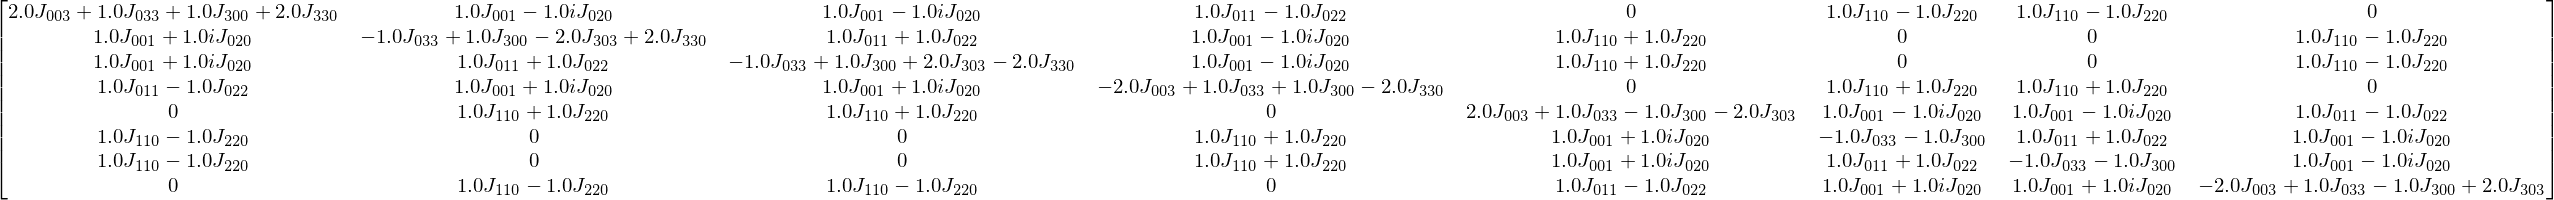

In [2]:
from qubit_network.analytical_conditions import commuting_generator
sympy.init_printing()
commuting_generator(qutip.fredkin(), interactions='diagonal')

Train a 3-qubit network to implement a Fredkin gate, starting with the above topology for the Hamiltonian

In [10]:
NetsDataFolder('../data/new_nets/').filter('fredkin*')

target gates                 names
0      fredkin     fredkin_diagonal5
1      fredkin     fredkin_diagonal2
2      fredkin      fredkin_diagonal
3      fredkin     fredkin_diagonal6
4      fredkin     fredkin_diagonal3
5      fredkin     fredkin_diagonal7
6      fredkin     fredkin_diagonal9
7      fredkin     fredkin_diagonal4
8      fredkin     fredkin_diagonal8
9      fredkin  fredkin_diagonal(10)

In [8]:
optimizer.save_results('../data/new_nets/fredkin_diagonal#10.pickle')

Successfully saved to ../data/new_nets/fredkin_diagonal#10.pickle


Compiling model ... done.


<IPython.core.display.Javascript object>


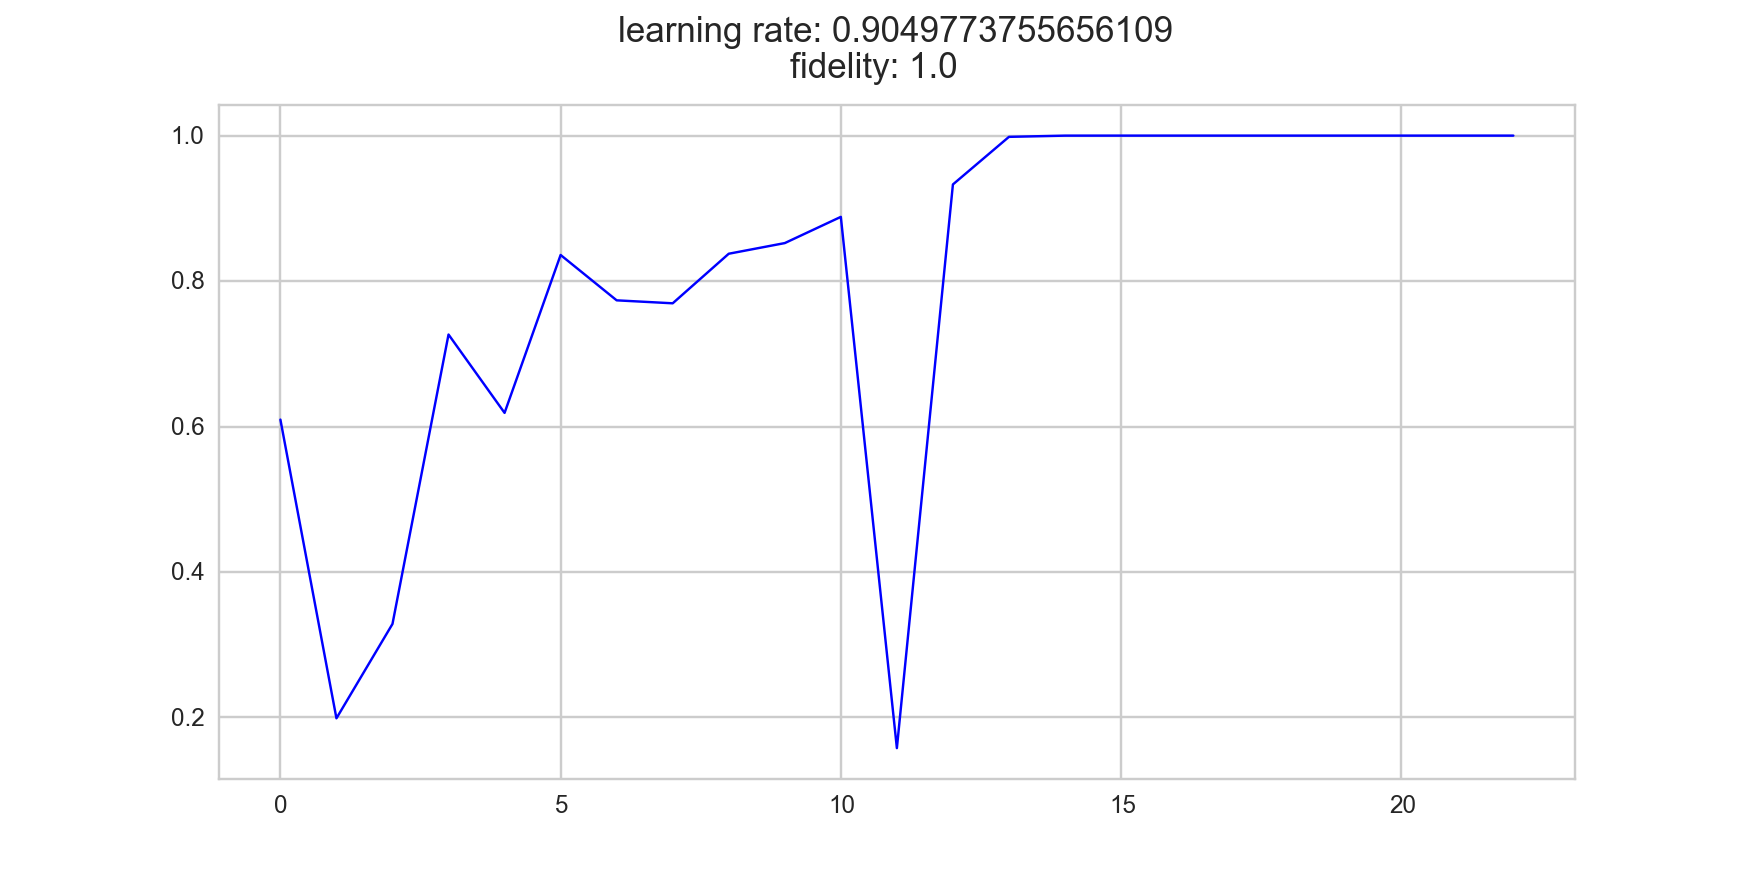

Fidelity 1 obtained, stopping.


In [15]:
from qubit_network.analytical_conditions import commuting_generator
fredkin_diagonal = commuting_generator(qutip.fredkin(), interactions='diagonal')
net = QubitNetworkGateModel(sympy_expr=fredkin_diagonal, initial_values=0)
optimizer = Optimizer(
    net=net,
    learning_rate=1.,
    decay_rate=.005,
    n_epochs=500,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=200,
    test_dataset_size=100,
    sgd_method='momentum'
)
optimizer.run()
# uncomment the following to save result in file
# optimizer.save_results('../data/new_nets/fredkin_diagonalXXX.pickle')

# Plots in paper

Look at all solutions for the Fredkin stored in `../data/new_nets`, extract the final sets of interactions for each one, and draw all the results in a single static plot.

<IPython.core.display.Javascript object>


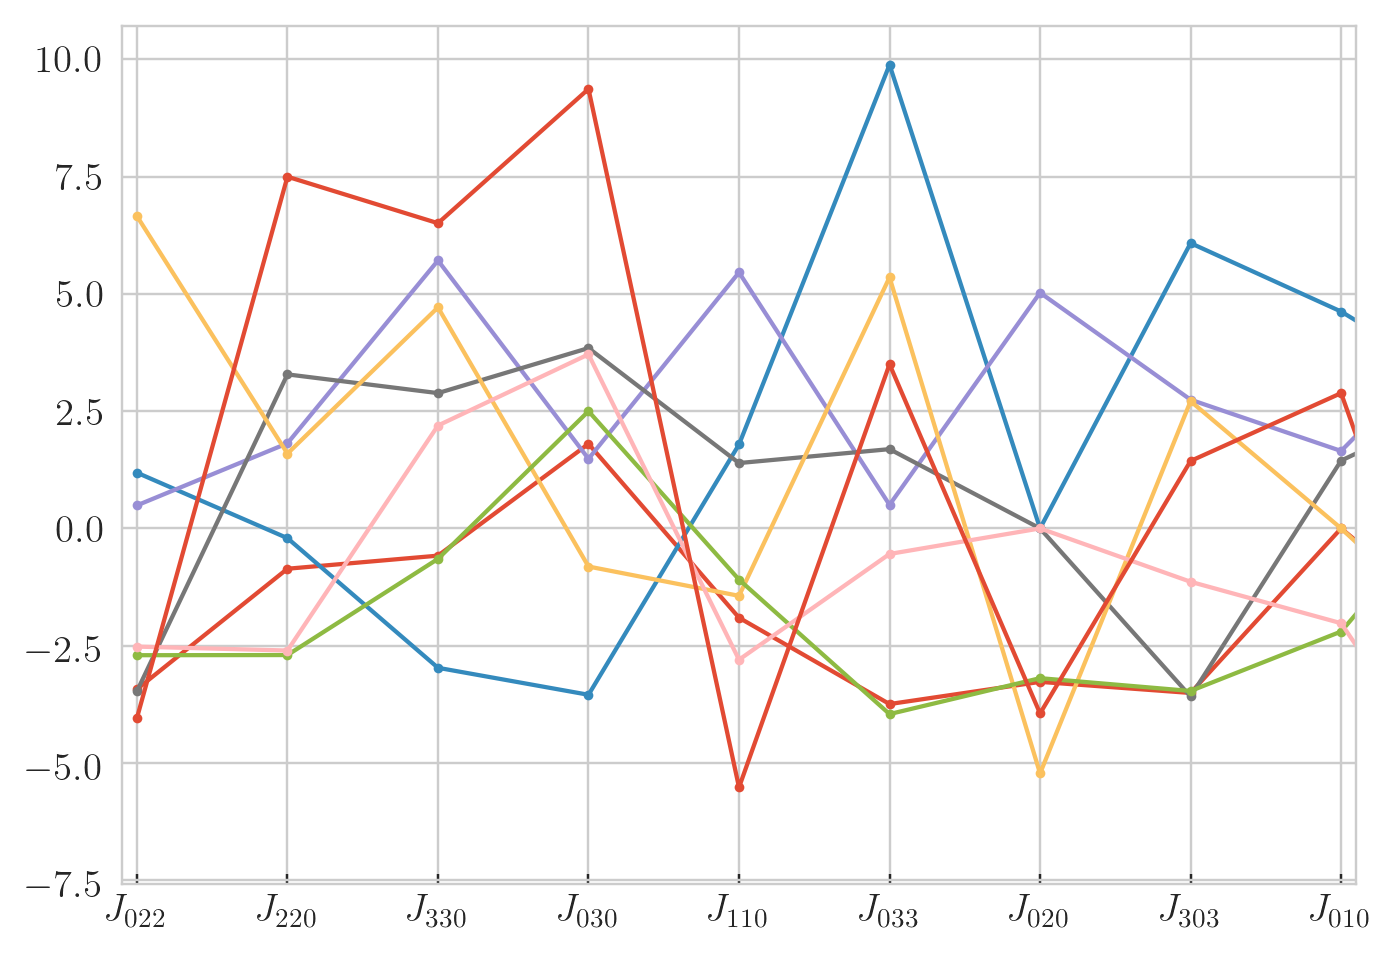

In [16]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig, ax = plt.subplots(1, 1)

ndf = NetsDataFolder('../data/new_nets/').filter('fredkin*')
df = ndf.view_parameters().sort_index(axis=1)
df.columns = [str(s) for s in range(df.shape[1])]
index_to_drop = np.where(np.abs(df.iloc[0, :]) > 15)[0][0]
df.drop(str(index_to_drop), axis=1, inplace=True)
df.plot(ax=ax, marker='o', markersize=4., legend=False)
# ax.set_title('Different solutions for Toffoli with diagonal interactions', fontsize=16)
# ax.set_xlabel('Parameters', fontsize=14)
# ax.set_ylabel('Values', fontsize=14)
# change font size of tick labels
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='x', length=4, direction='in')
# better range
ax.set_xlim(-0.1 , 8.1)
# mathify xaxis labels
ax.set_xticks(range(9))
xlabels = [label.get_text() for label in ax.get_xticklabels()]
def adjust_xlabel(text):
    return '$' + text[0] + '_{' + text[1:] + '}$'
ax.set_xticklabels([adjust_xlabel(label) for label in xlabels])
ax.set_xlabel('')
# fix sizes
plt.tight_layout()
# save to file (uncomment to actually save figure)
# fig.savefig('fredkin_diagonal_solutions.pdf', bbox_inches='tight')

fredkin_diagonal


<IPython.core.display.Javascript object>


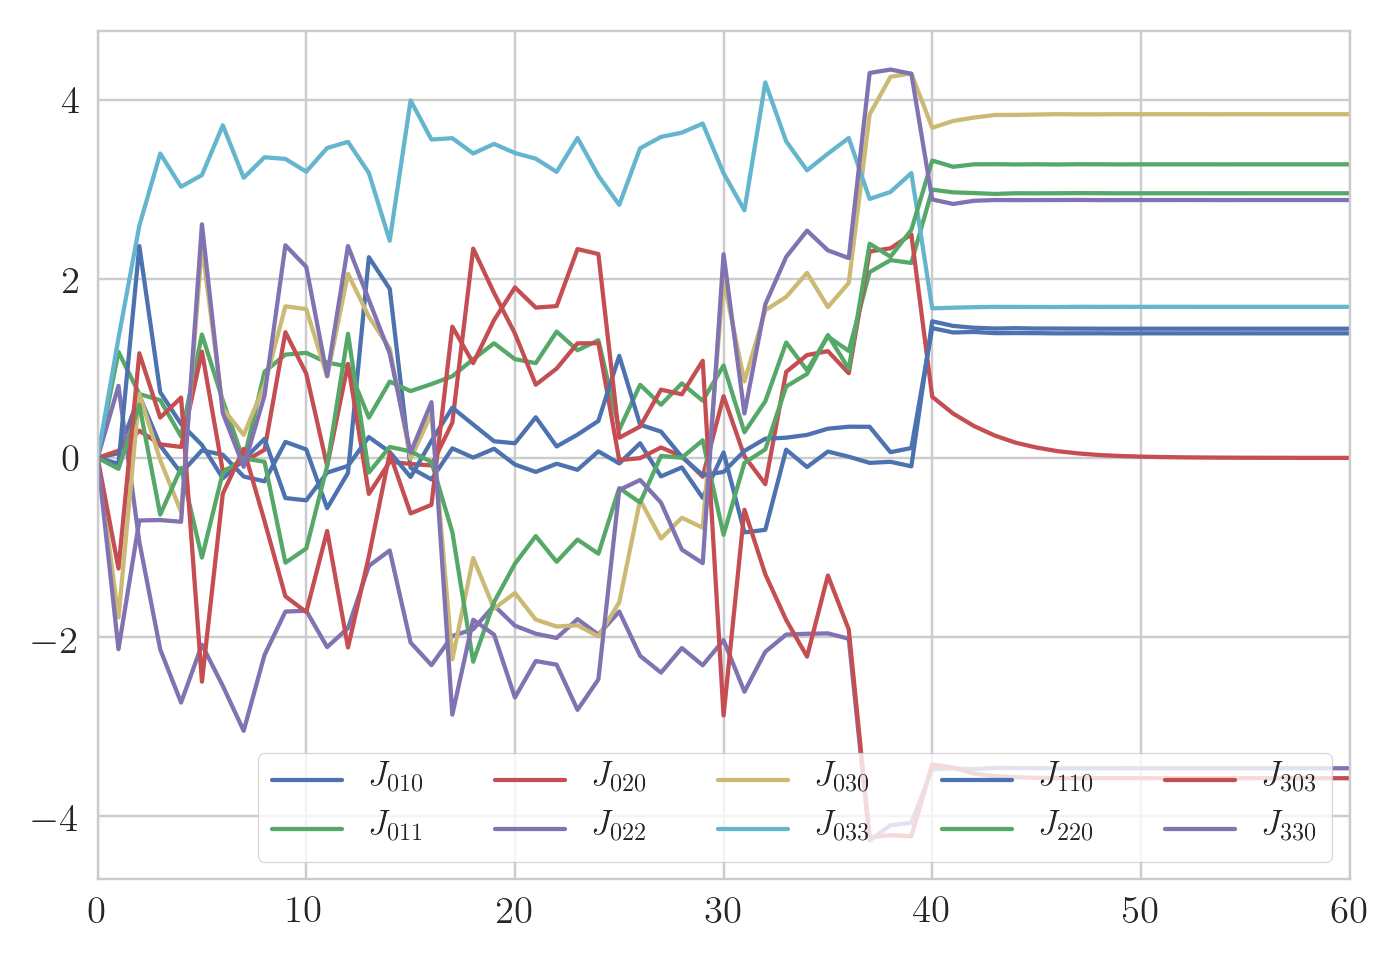

In [3]:
def _plot_parhistory(filename):
    # make output file name
    basename, ext = os.path.splitext(filename)
    basename = os.path.basename(basename)
    print(basename)
    out_filename = basename + '_parshistory.pdf'
    # set style
    plt.style.use('seaborn-whitegrid')
    # plt.style.use('ggplot')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    opt = Optimizer.load(filename)
    df = opt.plot_parameters_history(return_df=True).sort_index(axis=1)
    # adjust style of columns names
    def adjust_label(text):
        return '$' + text[0] + '_{' + text[1:] + '}$'
    df.columns = df.columns.map(adjust_label)
    # make new figure
    fig, ax = plt.subplots(1, 1)
    # plot
    df.plot(ax=ax, legend=False)
    # bigger tick labels
    ax.tick_params(axis='both', labelsize=16)
    # make legend
    legend = ax.legend(loc='lower right', ncol=5, frameon=True, fancybox=True, fontsize='large')
    # legend.get_frame().set_facecolor('#00FFCC')
    # legend.get_frame().set_edgecolor('green')
    legend.get_frame().set_linewidth(0.5)
    # fix layout
    plt.tight_layout()
import glob
plt.ion()
_plot_parhistory('../data/new_nets/fredkin_diagonal.pickle')

In [2]:
glob.glob('../data/new_nets/fredkin_diagonal*.pickle')

['../data/new_nets/fredkin_diagonal(01).pickle',
 '../data/new_nets/fredkin_diagonal(02).pickle',
 '../data/new_nets/fredkin_diagonal(03).pickle',
 '../data/new_nets/fredkin_diagonal(04).pickle',
 '../data/new_nets/fredkin_diagonal(05).pickle',
 '../data/new_nets/fredkin_diagonal(06).pickle',
 '../data/new_nets/fredkin_diagonal(07).pickle',
 '../data/new_nets/fredkin_diagonal(08).pickle',
 '../data/new_nets/fredkin_diagonal(09).pickle',
 '../data/new_nets/fredkin_diagonal(10).pickle',
 '../data/new_nets/fredkin_diagonal(11).pickle']

<IPython.core.display.Javascript object>


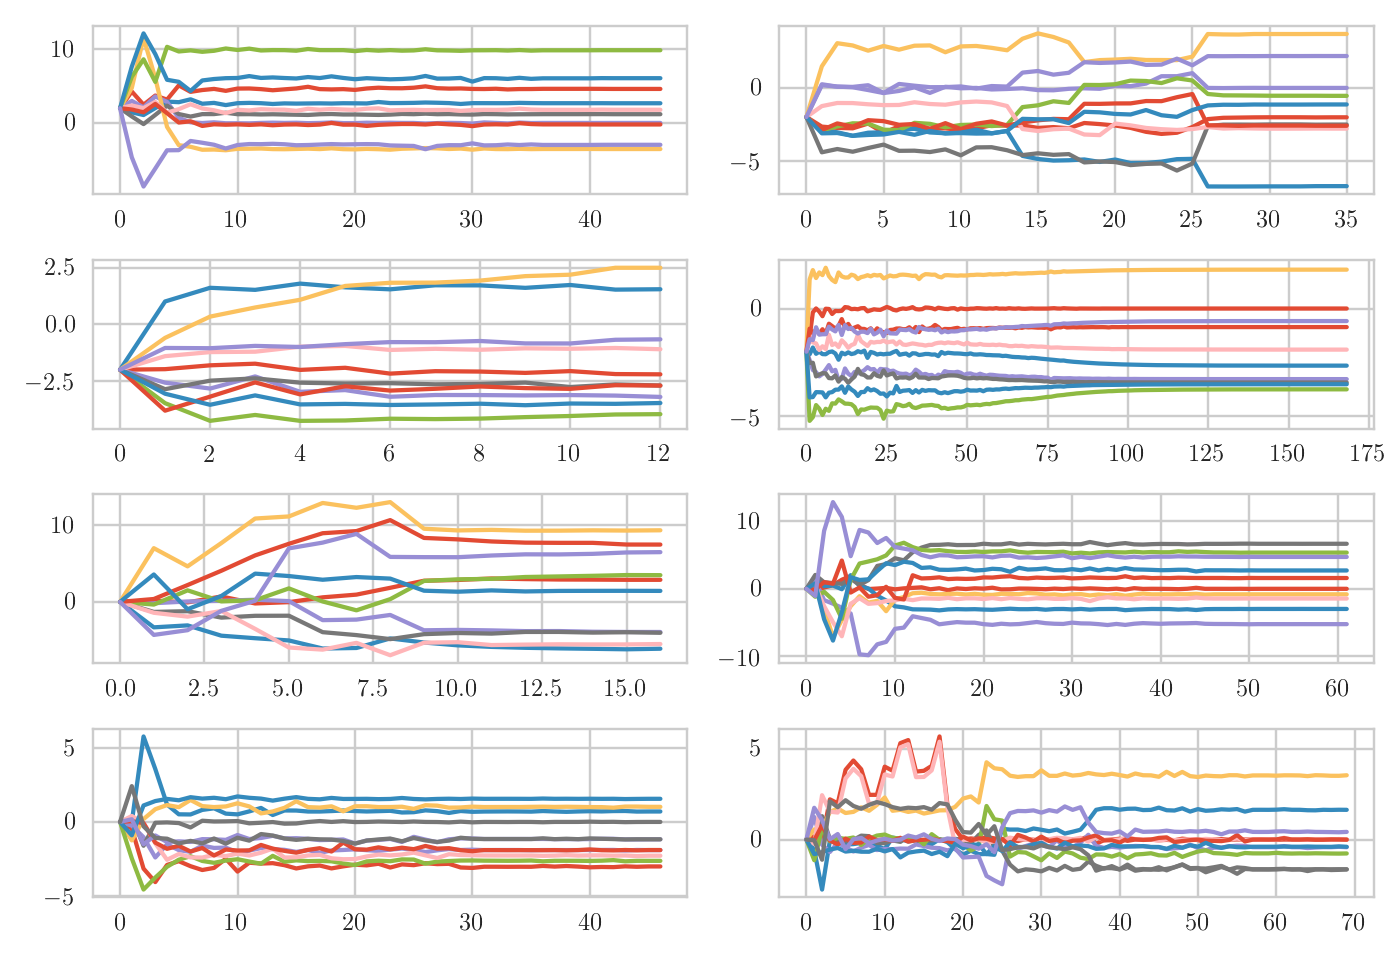

In [4]:
def _plot_pars_history(ax, filename):
    opt = Optimizer.load(filename)
    df = opt.plot_parameters_history(return_df=True).sort_index(axis=1)
    df.plot(ax=ax, legend=False)
    # bigger tick labels
    # ax.tick_params(axis='both', labelsize=16)
    # fix layout
    # plt.tight_layout()
    # save to file
    # fig.savefig(out_filename, bbox_inches='tight')

import glob
filenames = glob.glob('../data/new_nets/fredkin_diagonal*.pickle')[-8:]
# set style
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# make new figure
fig, axs = plt.subplots(4, 2)
for ax, filename in zip(axs.flatten(), filenames):
    _plot_pars_history(ax, filename)
plt.tight_layout()
fig.savefig('fredkin_diagonal_trainings.pdf', bbox_inches='tight')